In [197]:
from cv2 import aruco
import cv2
import numpy as np
import matplotlib.pyplot as plt
import msgpack as mp
import msgpack_numpy as mpn
import os

from tqdm import tqdm
import csv
import pandas as pd
import polars as pl
import sys
sys.path.append(os.path.join(os.getcwd(), '..'))
from support.pd_support import *

from numba import njit
from datetime import datetime

In [198]:
_pth = os.getcwd()
_pth = os.path.dirname(_pth)
_parent_folder = "cam_june_22_2023"
_calib_folder_name = "calibration_00"

_folder_name = "sk40_30_4_random_mocap_0"
# _folder_name = "board"

_base_pth = os.path.join(_pth,"recorded_data",_parent_folder)

_webcam_calib_folder = os.path.join(_pth,"recorded_data",_parent_folder,_calib_folder_name)
_webcam_calib_folder = os.path.join(_webcam_calib_folder)
_webcam_calib_pth = os.path.join( _webcam_calib_folder, "webcam_calibration.msgpack")

with open(_webcam_calib_pth, "rb") as f:
    webcam_calib = mp.Unpacker(f, object_hook=mpn.decode)
    _temp = next(webcam_calib)
    _webcam_cam_mat = _temp[0]
    _webcam_dist = _temp[1]

_webcam_cam_mat

array([[671.25534529,   0.        , 678.00736213],
       [  0.        , 692.23316717, 443.37269229],
       [  0.        ,   0.        ,   1.        ]])

In [199]:
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_ARUCO_ORIGINAL)
markerLength = 0.04
markerSeparation = 0.01

board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=markerLength,
        markerSeparation=markerSeparation,
        dictionary=ARUCO_DICT)

In [200]:
# timestamp
ts = []
ts_pth = os.path.join(_base_pth, _folder_name, "webcam_timestamp.msgpack")
ts_file = open(ts_pth, "rb")
ts_unpacker = mp.Unpacker(ts_file, object_hook=mpn.decode)
for ts_data in ts_unpacker:
    ts.append(ts_data)

In [201]:
_video_pth = os.path.join(_base_pth,_folder_name,"webcam_color.msgpack")
_video_file = open(_video_pth, "rb")
_video_data = mp.Unpacker(_video_file, object_hook=mpn.decode)

default_ids = [0, 49, 80]

data = {"frame_id":[],"marker_ids":[], "corners":[], "tvec":[], "rvec":[]}

counter = 0

for _frame in tqdm(_video_data):

    shape = _frame.shape
    gray = cv2.cvtColor(_frame, cv2.COLOR_BGR2GRAY)
    corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)

    corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
        image = gray,
        board = board,
        detectedCorners = corners,
        detectedIds = ids,
        rejectedCorners = rejectedImgPoints,
        cameraMatrix = _webcam_cam_mat,
        distCoeffs = _webcam_dist)

    rotation_vectors, translation_vectors, _ = aruco.estimatePoseSingleMarkers(corners, 0.04, _webcam_cam_mat, _webcam_dist)

    if ids is None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(None)
        data["corners"].append(None)
        data["tvec"].append(None)
        data["rvec"].append(None)

    if ids is not None:
        data["frame_id"].append(counter)
        data["marker_ids"].append(ids)
        data["corners"].append(corners)
        data["tvec"].append(translation_vectors)
        data["rvec"].append(rotation_vectors)

    counter+=1


_video_file.close()

533it [00:06, 87.49it/s]


In [202]:
coordinate = {"0":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "49":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]},
              "80":{"x":[], "y":[], "z":[], "rx":[], "ry":[], "rz":[]}}

doesnt_exist = [] # list of ids that doesnt exist in a frame

for i in range(len(data["frame_id"])):
    if data["marker_ids"][i] is not None:

        if default_ids[0] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[0])
        if default_ids[1] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[1])
        if default_ids[2] not in data["marker_ids"][i]:
            doesnt_exist.append(default_ids[2])

        for j in range(len(data["marker_ids"][i])):
            if data["marker_ids"][i][j] in default_ids:
                coordinate[str(data["marker_ids"][i][j][0])]["x"].append(data["tvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["y"].append(data["tvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["z"].append(data["tvec"][i][j][0][2])
                coordinate[str(data["marker_ids"][i][j][0])]["rx"].append(data["rvec"][i][j][0][0])
                coordinate[str(data["marker_ids"][i][j][0])]["ry"].append(data["rvec"][i][j][0][1])
                coordinate[str(data["marker_ids"][i][j][0])]["rz"].append(data["rvec"][i][j][0][2])
        for k in doesnt_exist:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)
        doesnt_exist = []
    else:
        for k in default_ids:
            coordinate[str(k)]["x"].append(np.nan)
            coordinate[str(k)]["y"].append(np.nan)
            coordinate[str(k)]["z"].append(np.nan)
            coordinate[str(k)]["rx"].append(np.nan)
            coordinate[str(k)]["ry"].append(np.nan)
            coordinate[str(k)]["rz"].append(np.nan)

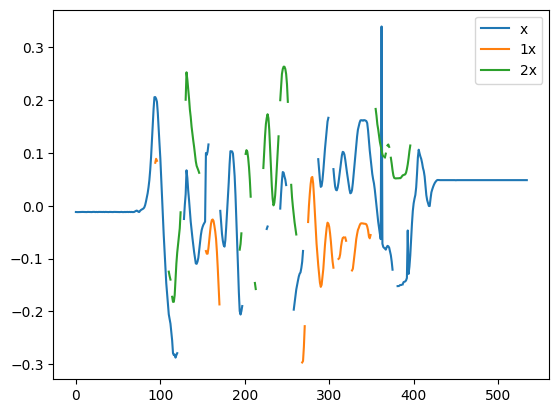

In [203]:
plt.plot(coordinate["0"]["x"], label="x")
plt.plot(coordinate["49"]["x"], label="1x")
plt.plot(coordinate["80"]["x"], label="2x")
plt.legend()

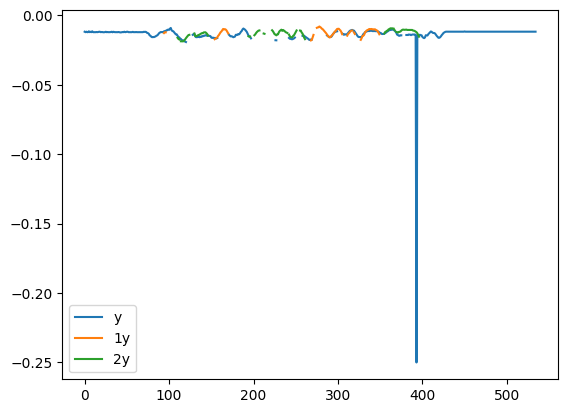

In [204]:
plt.plot(coordinate["0"]["y"], label="y")
plt.plot(coordinate["49"]["y"], label="1y")
plt.plot(coordinate["80"]["y"], label="2y")
plt.legend()

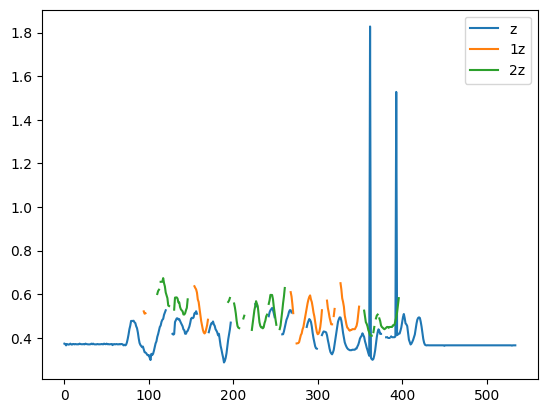

In [205]:
plt.plot(coordinate["0"]["z"], label="z")
plt.plot(coordinate["49"]["z"], label="1z")
plt.plot(coordinate["80"]["z"], label="2z")
plt.legend()

In [206]:
rmat = []
for i in range(len(coordinate["0"]["x"])):
    rotation_vectors = np.array([coordinate["0"]["rx"][i], coordinate["0"]["ry"][i], coordinate["0"]["rz"][i]])
    rotation_matrix = cv2.Rodrigues(rotation_vectors)[0]
    rmat.append(rotation_matrix)

In [207]:
df_0 = pd.DataFrame({"x":coordinate["0"]["x"], "y":coordinate["0"]["y"], "z":coordinate["0"]["z"]})
df_0 = pl.from_pandas(df_0)

tcoor_0 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["0"]["x"])):
    val = rmat[0].T @ (df_0[i].to_numpy() - df_0[0].to_numpy()).T

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_0["x"].append(x)
    tcoor_0["y"].append(y)
    tcoor_0["z"].append(z)

df_49 = pd.DataFrame({"x":coordinate["49"]["x"], "y":coordinate["49"]["y"], "z":coordinate["49"]["z"]})
df_49 = pl.from_pandas(df_49)

tcoor_49 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["49"]["x"])):
    val = rmat[0].T @ (df_49[i].to_numpy() - df_0[0].to_numpy()).T

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_49["x"].append(x)
    tcoor_49["y"].append(y)
    tcoor_49["z"].append(z)

df_80 = pd.DataFrame({"x":coordinate["80"]["x"], "y":coordinate["80"]["y"], "z":coordinate["80"]["z"]})
df_80 = pl.from_pandas(df_80)

tcoor_80 = {"x":[], "y":[], "z":[]}
for i in range(len(coordinate["80"]["x"])):
    val = rmat[0].T @ (df_80[i].to_numpy() - df_0[0].to_numpy()).T

    if val is None:
        x = np.nan
        y = np.nan
        z = np.nan
    else:
        x = val[0][0]
        y = val[1][0]
        z = val[2][0]
    tcoor_80["x"].append(x)
    tcoor_80["y"].append(y)
    tcoor_80["z"].append(z)

In [209]:
tcoor_df_0 = pd.DataFrame.from_dict(tcoor_0)
tcoor_df_49 = pd.DataFrame.from_dict(tcoor_49)
tcoor_df_80 = pd.DataFrame.from_dict(tcoor_80)

In [210]:
tcoor_df_49["time"] = ts
tcoor_df_80["time"] = ts
ts.append(ts[-1])
ts.append(ts[-1])
tcoor_df_0["time"] = ts

In [211]:

tcoor_df_0["time"] = pd.to_datetime(tcoor_df_0["time"])
tcoor_df_49["time"] = pd.to_datetime(tcoor_df_49["time"])
tcoor_df_80["time"] = pd.to_datetime(tcoor_df_80["time"])

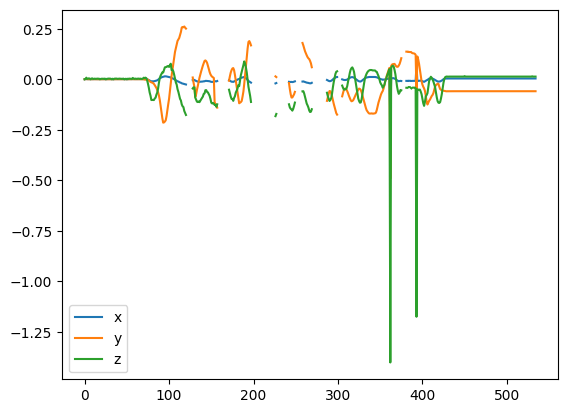

In [212]:
plt.plot(tcoor_0["x"], label="x")
plt.plot(tcoor_0["y"], label="y")
plt.plot(tcoor_0["z"], label="z")
plt.legend()

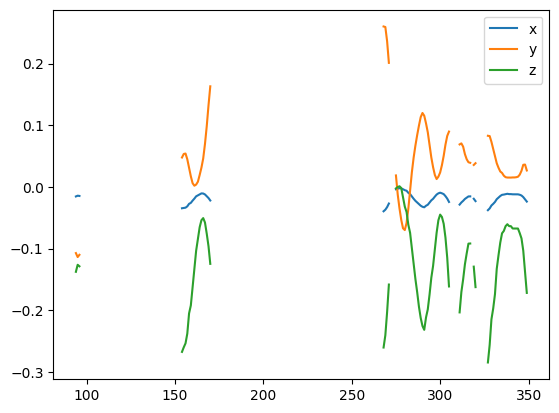

In [213]:
plt.plot(tcoor_49["x"], label="x")
plt.plot(tcoor_49["y"], label="y")
plt.plot(tcoor_49["z"], label="z")
plt.legend()

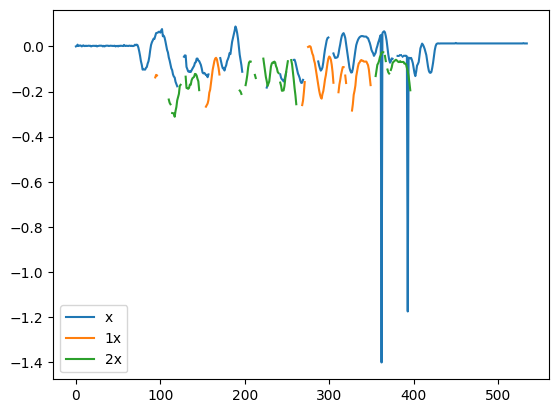

In [214]:
plt.plot(tcoor_0["z"], label="x")
plt.plot(tcoor_49["z"], label="1x")
plt.plot(tcoor_80["z"], label="2x")
plt.legend()

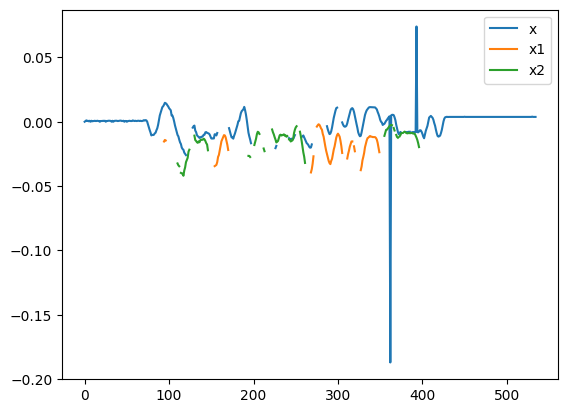

In [215]:
plt.plot(tcoor_0["x"], label="x")
plt.plot(tcoor_49["x"], label="x1")
plt.plot(tcoor_80["x"], label="x2")
plt.legend()

In [216]:
_mocap_pth = r"C:\Users\CMC\Documents\openposelibs\pose\DeepVision\recorded_data\cam_june_22_2023\sk40\sk40_30_4_random_mocap_0.csv"
_mocap_df, st_time = read_rigid_body_csv(_mocap_pth)
_mocap_df = add_datetime_col(_mocap_df, st_time, "seconds")

In [217]:
_om = get_rb_marker_name(3)
_xm = get_rb_marker_name(4)
_zm = get_rb_marker_name(1)

In [218]:
"""
checking position
defining initial frame of reference
"""

xvec = [_mocap_df[_xm["x"]].iloc[0], _mocap_df[_xm["y"]].iloc[0], _mocap_df[_xm["z"]].iloc[0]]
xvec = np.array(xvec).reshape(3,1)

zvec = [_mocap_df[_zm["x"]].iloc[0], _mocap_df[_zm["y"]].iloc[0], _mocap_df[_zm["z"]].iloc[0]]
zvec = np.array(zvec).reshape(3,1)

org = [_mocap_df[_om["x"]].iloc[0], _mocap_df[_om["y"]].iloc[0], _mocap_df[_om["z"]].iloc[0]]
org = np.array(org).reshape(3,1)

v1 = xvec - org  # v1
v2 = zvec - org  # v2

vxnorm = v1 / np.linalg.norm(v1)

vzcap = v2 - (vxnorm.T @ v2) * vxnorm
vznorm = vzcap / np.linalg.norm(vzcap)

vynorm = np.cross(vznorm.T[0], vxnorm.T[0]).reshape(3, 1)
rotMat = np.hstack((vxnorm, vynorm, vznorm)) # rotation matrix

In [219]:
@njit
def apply_rot_mat(mc_val, rotMat, org):
    return (rotMat.T @ (mc_val - org)).T[0]

In [220]:
# This cell is optimized to run faster using polars
_mc_df = _mocap_df[["time", _om["x"], _om["y"], _om["z"]]].copy()
_mc_df = _mc_df.rename(columns={_om["x"]: "x", _om["y"]: "y", _om["z"]: "z"})
# _mc_df = _mc_df.astype({"x": np.float64, "y": np.float64, "z": np.float64})

_mc_pl_df = pl.from_pandas(_mc_df)

my_dict = {"x":[],"y":[],"z":[]}

for i in tqdm(range(len(_mc_df))):
    _x, _y, _z = apply_rot_mat(_mc_pl_df[i, 1:].to_numpy().T, rotMat, org)
    my_dict["x"].append(_x)
    my_dict["y"].append(_y)
    my_dict["z"].append(_z)	

_mc_df["x"] = my_dict["x"]
_mc_df["y"] = my_dict["y"]
_mc_df["z"] = my_dict["z"]

100%|██████████| 4878/4878 [00:00<00:00, 5152.52it/s]


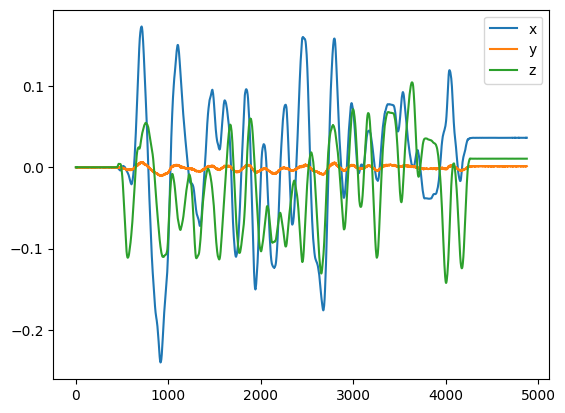

In [221]:
plt.plot(_mc_df["x"], label="x")
plt.plot(_mc_df["y"], label="y")
plt.plot(_mc_df["z"], label="z")
plt.legend()

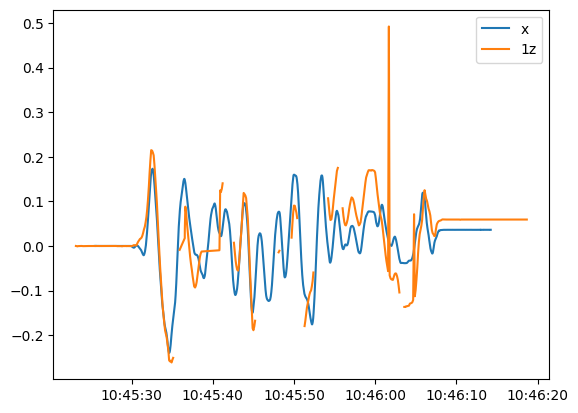

In [231]:
plt.plot(_mc_df["time"],_mc_df["x"], label="x")
plt.plot(tcoor_df_0["time"], -tcoor_df_0["y"], label = "1z")
plt.legend()
